In [1]:
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import pandas as pd
import numpy as np
import os
import shutil
import pickle

In [2]:
# Add the python path to the folder containing some custom packages.
import sys
sys.path.insert(0, "../")
from _utils import *

In [3]:
# Set default sizes for figures.
plt.style.use("default") # style matplotlib
plt.rc("axes", labelsize = 18) # fontsize of the x and y labels
plt.rc("axes", titlesize = 18) # fontsize of the axes title
plt.rc("xtick", labelsize = 15) # fontsize of the tick labels
plt.rc("ytick", labelsize = 15) # fontsize of the tick labels
plt.rc("legend", fontsize = 15) # legend fontsize

# Analysis

In [4]:
PROJECT_ROOT = "./RESULTS/Review 2"

## Configuration

In [5]:
COUNTRY = "Cameroon"

DIR_RESULTS = f"{PROJECT_ROOT}/{COUNTRY}"
OUTPUT_FOLDER = f"{PROJECT_ROOT}/{COUNTRY}/standard/out_test/images"

if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

In [6]:
## Forecasting results.

# Load forecasting results for each split.
xls = pd.ExcelFile(DIR_RESULTS + "/standard/out_test/forecast.xlsx")

forecast_splits = dict()
for i, split in enumerate(xls.sheet_names[1:]):
    forecast_split = pd.read_excel(xls, split, index_col = 0, header = [0, 1, 2])
    print(f"{split}: {forecast_split.index[0].date()} - {forecast_split.index[-1].date()}")
    # Reset the index.
    forecast_split.index = np.arange(1, len(forecast_split) + 1)
    forecast_split.index.names = ["Prediction horizon"]
    # Save the predictions.
    forecast_splits[split] = forecast_split
    
forecast_splits = pd.concat(forecast_splits, axis = 1)

Split 1: 2021-10-01 - 2021-10-30
Split 2: 2021-11-01 - 2021-11-30
Split 3: 2021-12-01 - 2021-12-30
Split 4: 2022-01-01 - 2022-01-30
Split 5: 2022-02-01 - 2022-03-02


In [7]:
# Select what splits to consider for the current analysis.
SELECT_SPLITS = [1,2,3,4,5]

In [8]:
# Load the training shapes for each split and prediction horizon.
training_shape = pd.read_csv(DIR_RESULTS + "/standard/out_test/training_shapes.csv", header = [0, 1], index_col = 0)
training_shape = training_shape[["Split " + str(s) for s in SELECT_SPLITS]] # Filter

# Load the losses for each split and province (model and naive).
loss_sites = pd.read_csv(DIR_RESULTS + "/standard/out_test/loss_sites.csv", index_col = [0, 1], header = [0, 1])
loss_sites = loss_sites[["Split " + str(s) for s in SELECT_SPLITS]] # Filter

# Load the losses for each split and prediction horizon (model and naive).
loss_h = pd.read_csv(DIR_RESULTS + "/standard/out_test/loss_h.csv", index_col = [0, 1], header = [0, 1])
loss_h = loss_h[["Split " + str(s) for s in SELECT_SPLITS]] # Filter

# Load the r2 for each split and prediction horizon (model and naive).
r2_results = pd.read_csv(DIR_RESULTS + "/standard/out_test/r2_results.csv", index_col = 0, header = [0, 1, 2])
r2_results = r2_results.loc[:, r2_results.columns.get_level_values(1).isin(["Split " + str(s) for s in SELECT_SPLITS])] # Filter

# Load all the configurations tested during hyperpameter tuning.
hyper_params = pd.read_csv(DIR_RESULTS + "/standard/hyperparameter_tuning.csv")
hyper_params = hyper_params[hyper_params["split"].isin(SELECT_SPLITS)] # Filter

In [9]:
loss_h.mean()#.groupby(axis = 0, level = 1).mean()

Split    Type     
Split 1  mse_model    13.515728
         mse_naive     6.561819
Split 2  mse_model    25.377560
         mse_naive    18.706517
Split 3  mse_model    18.771959
         mse_naive    19.703658
Split 4  mse_model    45.976552
         mse_naive    39.618010
Split 5  mse_model    19.332415
         mse_naive    21.954601
dtype: float64

## Figures

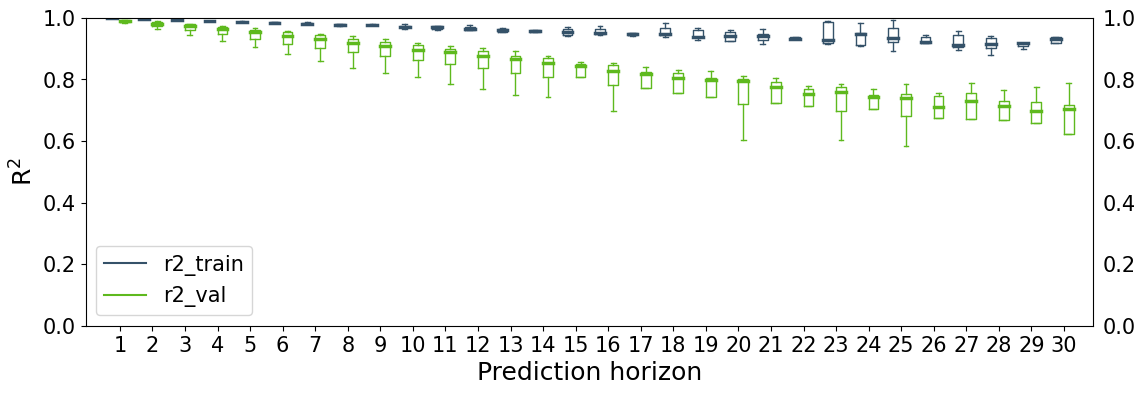

In [10]:
# For each split and prediction horizon, we get the best configuration according to the minimum of the 'loss_to_minimize'.
best_results = hyper_params.loc[hyper_params.groupby(["split", "h"])["loss_to_minimize"].idxmin()].set_index(["split", "h"])

# Isolate the shapes of the training and validation data for each split and prediction horizon.
shapes = best_results[["shape_train", "shape_val"]].applymap(eval)    
shapes["train_points"], shapes["features"] = zip(*shapes["shape_train"])
shapes["val_points"], _ = zip(*shapes["shape_val"])
shapes.drop(["shape_train", "shape_val"], axis = 1, inplace = True)    
shapes = shapes.unstack("h").stack(0)

# Get the r2 results corresponding to the best configurations.
best_r2 = best_results[["r2_train", "r2_val"]].unstack("split").reorder_levels([1, 0], axis = 1).sort_index(axis = 1, level = [0, 1])

# Create boxplot r2 over all the splits.
fig, ax = plt.subplots(figsize = (13, 4))    
plot_r2_box_plot(best_r2, ax, label1 = "r2_train", label2 = "r2_val", color1 = "#355269", color2 = "#5eb91e")
ax.set_ylim(0, 1)

# Save figure.
fig.savefig(OUTPUT_FOLDER + "/r2_hyper.png" , bbox_inches = "tight", dpi = 300)

# Create 'boxplot' for each split.
#SPLITS = best_r2.columns.get_level_values("split").unique()
#for split in SPLITS:
#    fig, ax = plt.subplots(figsize = (10, 3))    
#    plot_r2_box_plot(best_r2[[split]], ax, label1 = "r2_train", label2 = "r2_val", title = f"Split {split}",
#                     table = shapes.loc[split], color1 = "#355269", color2 = "#5eb91e")

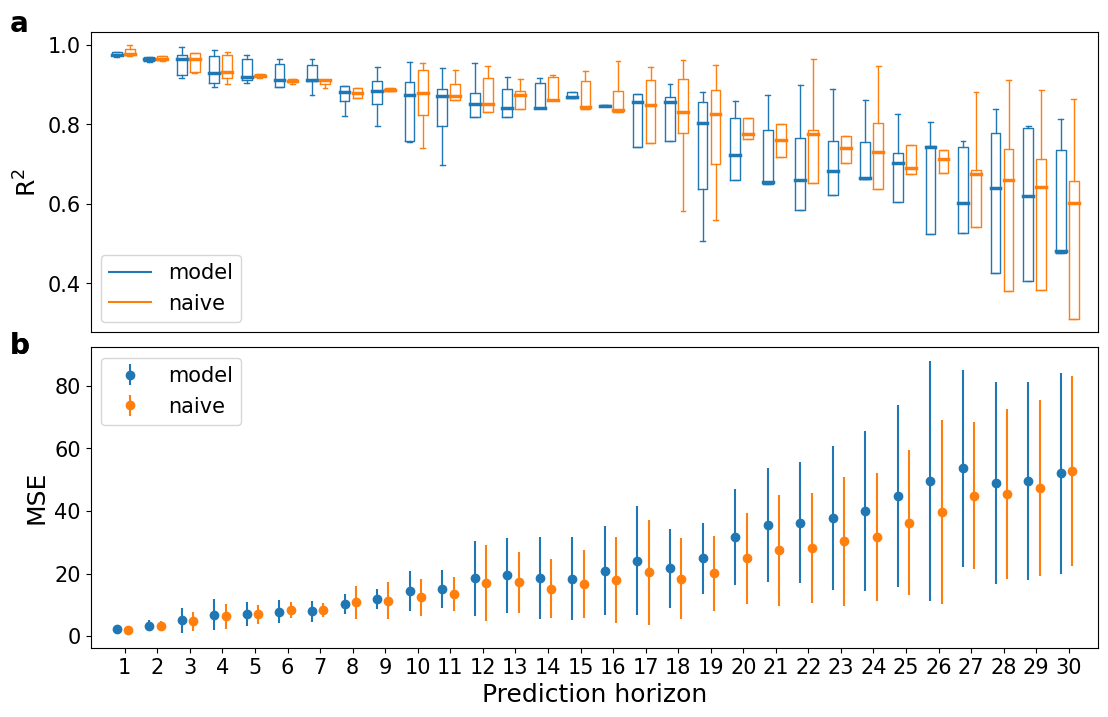

In [11]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (13, 8), sharex = True)    
fig.subplots_adjust(hspace = .05)

## Loss of each split as function of the prediction horizon.

colors = [sns.color_palette("tab10")[0], sns.color_palette("tab10")[1]]

## r2 scores

r2_results.rename({"r2_model": "model", "r2_naive": "naive"}, axis = 1, level = 2, inplace = True)

COUNTRIES = r2_results.columns.get_level_values(0).unique()
SPLITS = r2_results.columns.get_level_values(1).unique()

for country in COUNTRIES:   
    plot_r2_box_plot(r2_results[country], axs[0], "model", "naive")
    axs[0].tick_params(labelright = False)
    axs[0].text(-0.08, 1., "a", transform = axs[0].transAxes, 
                size = 20, weight='bold')
    #axs[0].set_ylim([, 1])
    
## Total loss over the splits as function of the prediction horizon.

loss_h.rename({"mse_model": "model", "mse_naive": "naive"}, axis = 1, level = 1, inplace = True)
        
# Mean and standard deviation.

COUNTRIES = loss_h.index.get_level_values(0).unique()
SPLITS = loss_h.columns.get_level_values(0).unique()
MODELS = loss_h.columns.get_level_values(1).unique()

for j, country in enumerate(COUNTRIES):
    for i, m in enumerate(MODELS):  
        value = loss_h.loc[country].xs(m, axis = 1, level = 1, drop_level = False)
        value_statistic = value.agg([np.mean, np.std], axis = 1)
        value_statistic.columns = ["mean", "std"]

        # Plot.
        if i == 0:
            trans1 = Affine2D().translate(-0.5, 0.0) + axs[1].transData
            axs[1].errorbar(axs[0].get_xticks(), value_statistic["mean"], yerr = value_statistic["std"], marker = "o", 
                         linestyle = "none", transform = trans1, c = colors[i], label = m)
        else:
            trans2 = Affine2D().translate(+0.2, 0.0) + axs[1].transData
            axs[1].errorbar(axs[0].get_xticks(), value_statistic["mean"], yerr = value_statistic["std"], marker = "o", 
                         linestyle = "none", transform = trans2, c = colors[i], label = m)
        
        # Set attributes of the plot.
        axs[1].legend(loc = "upper left")
        axs[1].set_xlabel("Prediction horizon")
        axs[1].set_ylabel("MSE")
        
        axs[1].text(-0.08, 0.98, "b", transform = axs[1].transAxes, 
                size = 20, weight='bold')
        
axs[0].axes.get_xaxis().set_visible(False)
fig.savefig(OUTPUT_FOLDER + "/metrics.png", bbox_inches = "tight", dpi = 300)

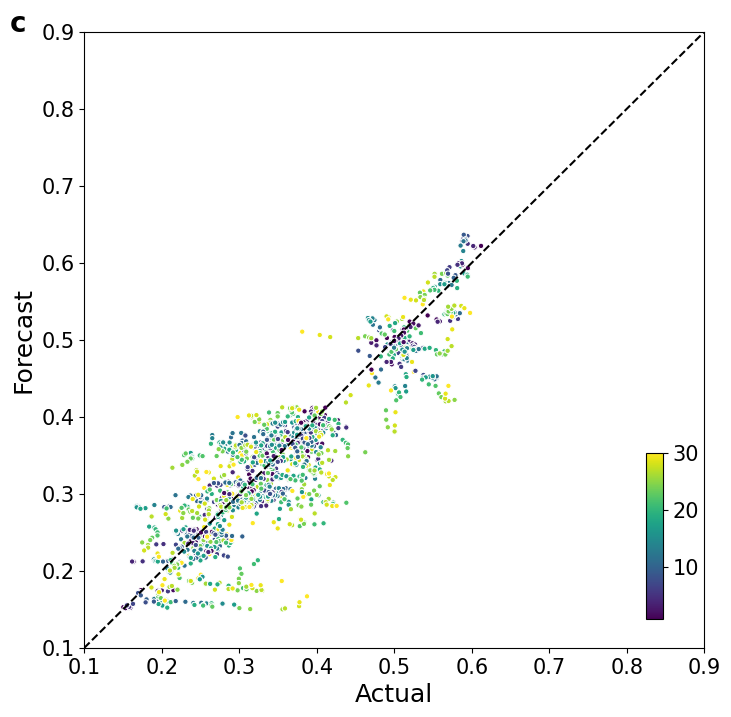

In [12]:
## Actual vs Forecast

COUNTRIES = forecast_splits.columns.get_level_values(1).unique()
SPLITS = forecast_splits.columns.get_level_values(0).unique()

for country in COUNTRIES:
    PROVINCES = forecast_splits.xs(country, axis = 1, level = 1).columns.get_level_values(1).unique()
    colors = {split: plt.get_cmap("tab20")(i) for i,split in enumerate(SPLITS)}
    
    fig, axs = plt.subplots(figsize = (8, 8))
    # Add bisector.
    axs.plot(axs.get_xlim(), axs.get_ylim(), color = "black", linestyle = "--")

    for i,split in enumerate(SPLITS):
        predictions = forecast_splits[(split, country)]
        predictions = predictions.drop(["Naive"], axis = 1, level = 1)
        predictions = predictions/100
   
        def plot_scatter(group):
            gr = group[group.name]
            gr.rename({"FCG": "Actual"}, axis = 1, level = 0, inplace = True)
            sns.scatterplot(data = gr, x="Actual", y = "Forecast", hue = gr.index, s = 15, ax = axs, 
                            legend = False, palette = "viridis")

        predictions.groupby(axis = 1, level = 0).apply(plot_scatter)

        # Legend.
        axs.set_xlim(0.1, 0.9)
        axs.set_ylim(0.1, 0.9)
    
    norm = plt.Normalize(1, 30)
    sm = plt.cm.ScalarMappable(cmap = "viridis", norm = norm)
    sm.set_array([])
    cbaxes = inset_axes(axs, width = "3%", height = "30%", loc = "lower right", bbox_to_anchor = (0.05,0.03,.9,.9), 
                        bbox_transform = axs.transAxes) 
    axs.figure.colorbar(sm, cax = cbaxes)
    
    axs.text(-0.12, 1., "c", transform = axs.transAxes, 
             size = 20, weight='bold')

    fig.savefig(OUTPUT_FOLDER + "/scatter.png", bbox_inches = "tight", dpi = 300)

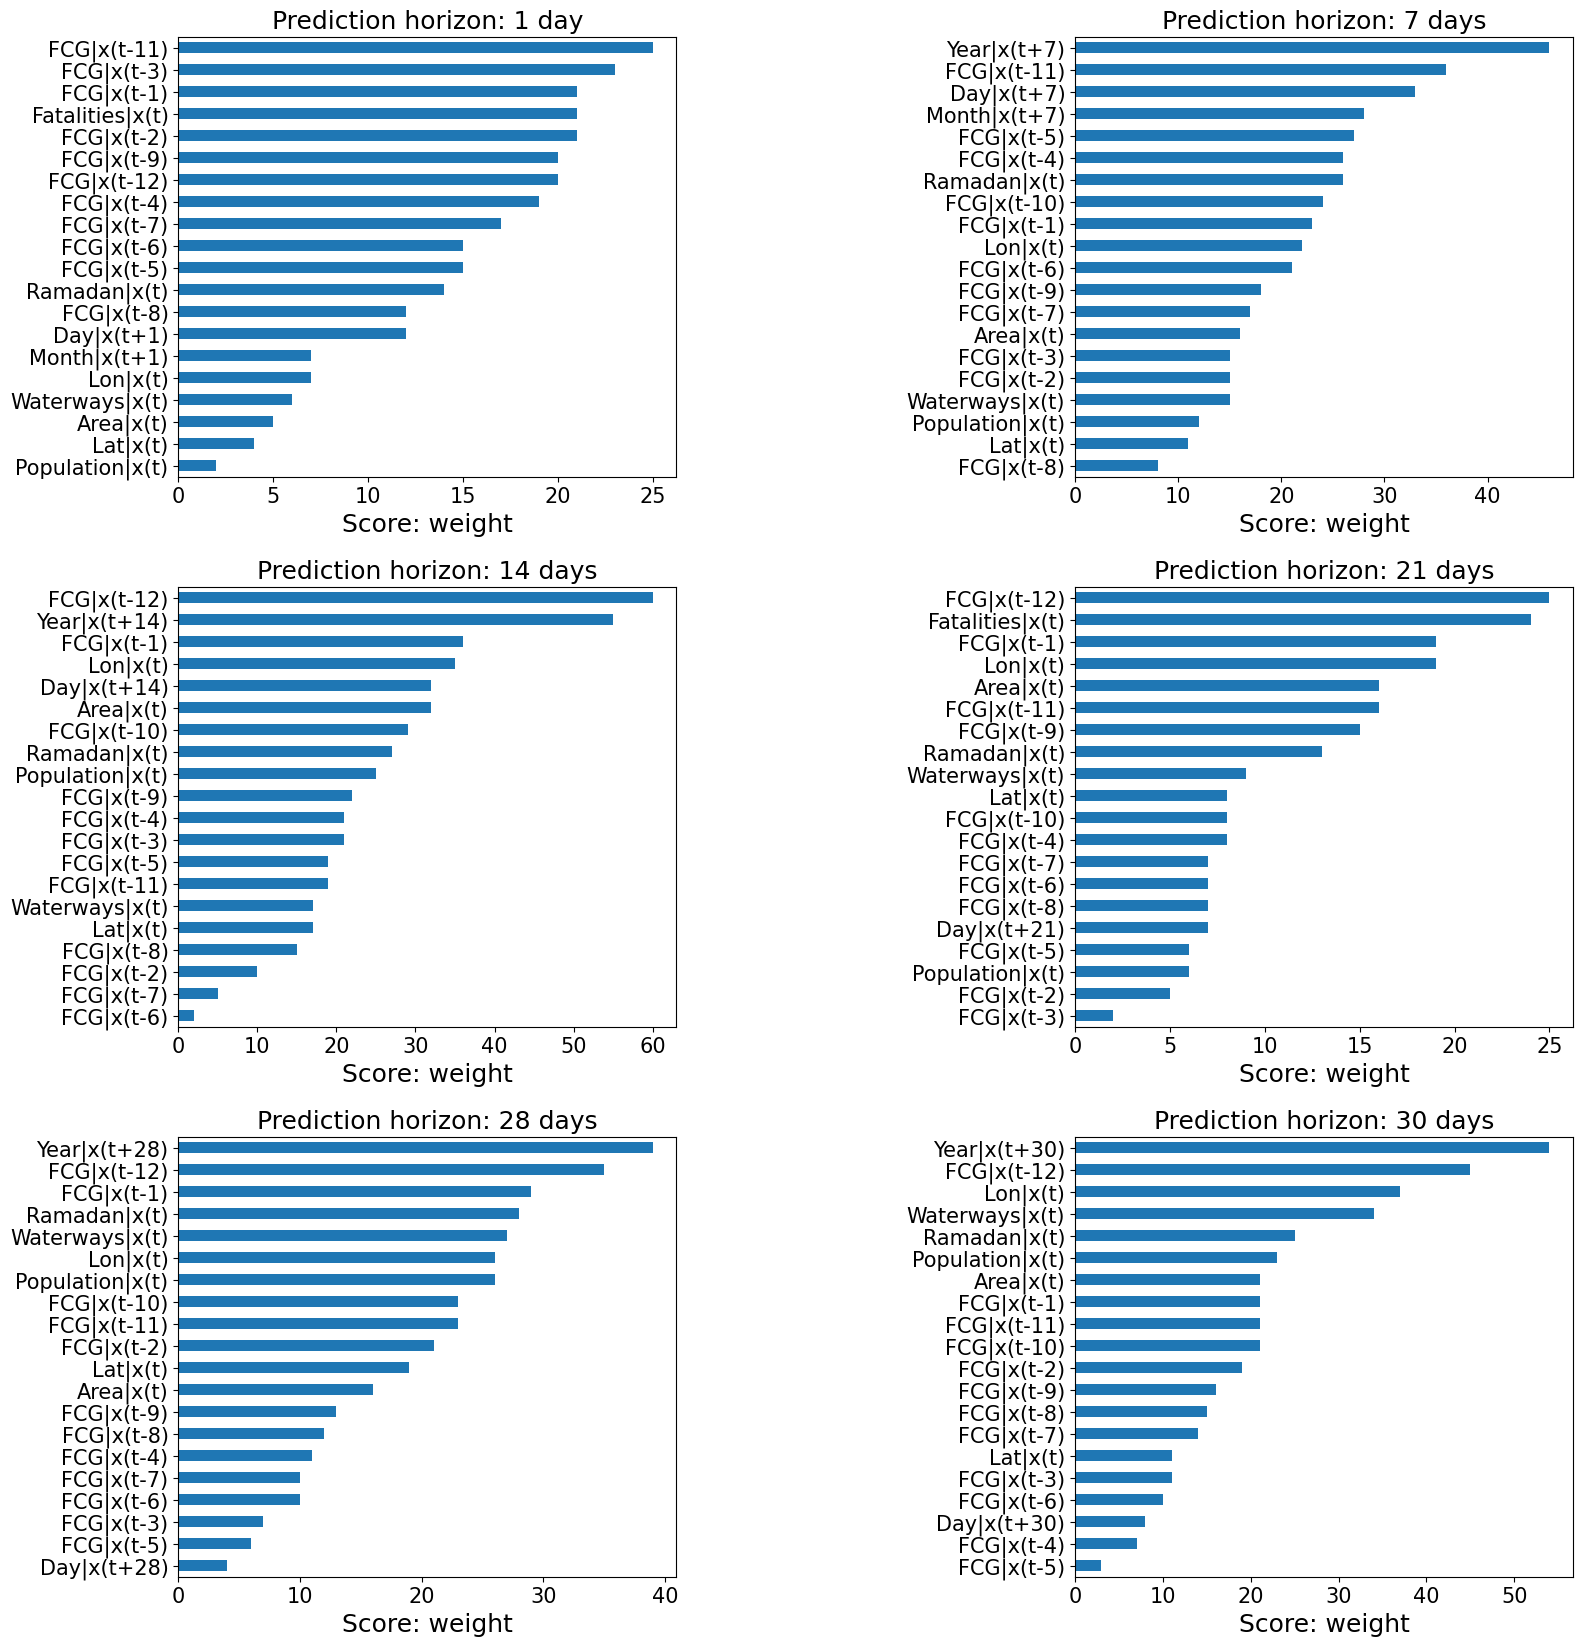

In [13]:
## Features importance.
prediction_horizons = [1, 7, 14, 21, 28, 30]

# Keep last split to compute feature importance.
SPLIT = r2_results.columns.get_level_values("Split").nunique()

fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (18, 20))
fig.subplots_adjust(wspace = 0.8, hspace = 0.25)

axs = axs.ravel()
for i, h in enumerate(prediction_horizons):
    with open(DIR_RESULTS + f"/standard/out_test/features_importance/features_split_{SPLIT}_h_{h}", "rb") as fp:
        f_imp = pickle.load(fp)
    
    # Create histogram feature importance.
    keys = list(f_imp.keys())
    values = list(f_imp.values())
    data = pd.DataFrame(data = values, index = keys, columns = ["score"]).sort_values(by = "score", ascending = True)   
    data = data.head(20)
    data.plot(kind = "barh", ax = axs[i])
    if h == 1:
        axs[i].set_title(f"Prediction horizon: {h} day")
    else:
        axs[i].set_title(f"Prediction horizon: {h} days")
    axs[i].legend_ = None
    axs[i].set_xlabel("Score: weight")
    
# Remove extra plot.
#axs[-1].set_axis_off()
    
fig.savefig(OUTPUT_FOLDER + "/importance.png", bbox_inches = "tight", dpi = 300)